In [8]:
# 7. Data Preprocessing

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load dataset
df = pd.read_csv("customer.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Drop customerID (not useful for prediction)
df.drop("customerID", axis=1, inplace=True)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Encode binary columns
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

# One-hot encode other categorical variables
df = pd.get_dummies(df, drop_first=True)

# Feature scaling
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])
print("Initial data shape:", df.shape)
print("Missing values after conversion:", df.isnull().sum().sum())
print("Columns after encoding and scaling:")
print(df.columns.tolist())
print("Final data shape after preprocessing:", df.shape)

Initial data shape: (198, 31)
Missing values after conversion: 0
Columns after encoding and scaling:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
Final data shape after preprocessing: (198, 31)


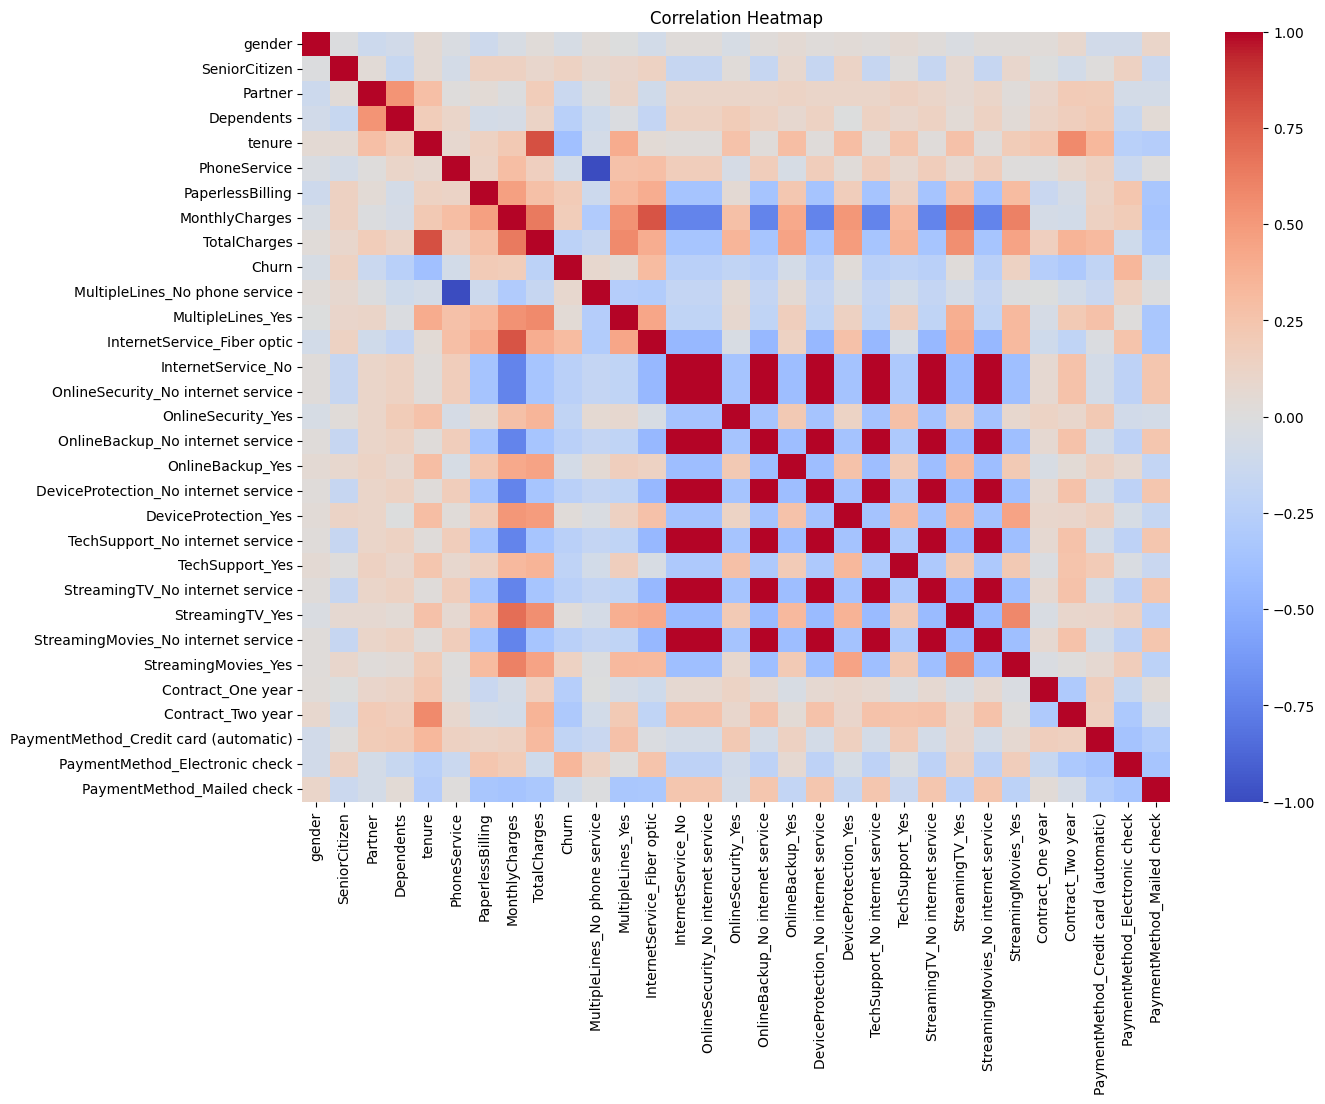

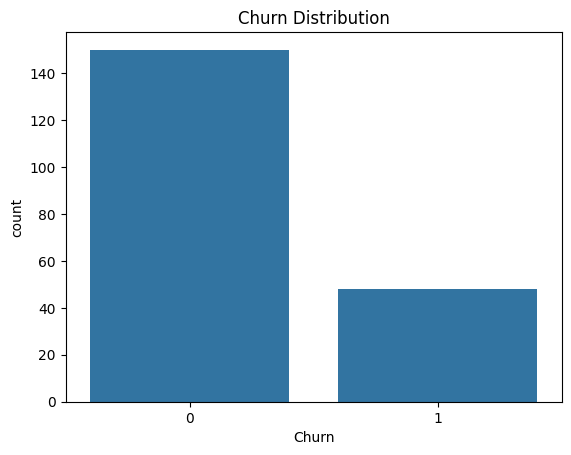

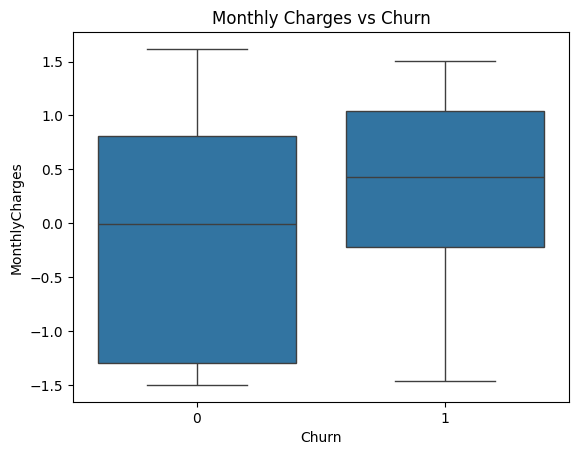

In [3]:
# 8. Exploratory Data Analysis (EDA)

# Correlation heatmap
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Churn distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

# Boxplot for MonthlyCharges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

In [9]:

# 9. Feature Engineering

# Define input and output
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Input features shape (X):", X.shape)
print("Target variable distribution:\n", y.value_counts())
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Input features shape (X): (198, 30)
Target variable distribution:
 Churn
0    150
1     48
Name: count, dtype: int64
Training set shape: (158, 30)
Test set shape: (40, 30)


In [11]:
# 10. Model Building
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} - Training Accuracy: {model.score(X_train, y_train):.4f}")
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss')  # Removed use_label_encoder
xgb.fit(X_train, y_train)
xgb_train_acc = accuracy_score(y_train, xgb.predict(X_train))
print("XGBoost - Training Accuracy: {:.4f}".format(xgb_train_acc))

Logistic Regression - Training Accuracy: 0.8797
Random Forest - Training Accuracy: 1.0000
XGBoost - Training Accuracy: 0.9937
XGBoost - Training Accuracy: 0.9937


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Logistic Regression Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.77      0.81        31
           1       0.42      0.56      0.48         9

    accuracy                           0.72        40
   macro avg       0.64      0.66      0.64        40
weighted avg       0.76      0.72      0.74        40

Confusion Matrix:
 [[24  7]
 [ 4  5]]
ROC AUC Score: 0.7634408602150538

Random Forest Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85        31
           1       0.50      0.56      0.53         9

    accuracy                           0.78        40
   macro avg       0.68      0.70      0.69        40
weighted avg       0.78      0.78      0.78        40

Confusion Matrix:
 [[26  5]
 [ 4  5]]
ROC AUC Score: 0.7491039426523297

XGBoost Evaluation:
Classification Report:
               precision    recall  f1-score   sup

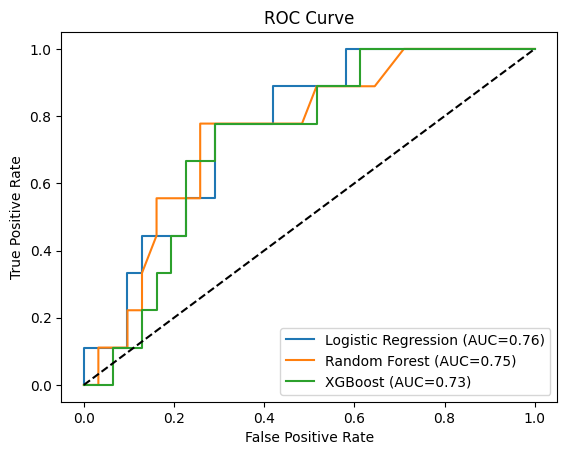

Best model saved as 'best_churn_model.pkl'
Model features saved as 'model_features.pkl'


In [7]:
# 11. Model Evaluation and Save Best Model for Deployment

import joblib
best_model = None
best_auc = 0

for name, model in models.items():
    print(f"\n{name} Evaluation:")
    y_pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    auc = roc_auc_score(y_test, proba)
    print("ROC AUC Score:", auc)

    # Plot ROC
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

    # Save the best model
    if auc > best_auc:
        best_auc = auc
        best_model = model

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Save the best model
joblib.dump(best_model, "best_churn_model.pkl")
print("Best model saved as 'best_churn_model.pkl'")

# Save column list (used in deployment)
joblib.dump(X.columns.tolist(), "model_features.pkl")
print("Model features saved as 'model_features.pkl'")